# CIFAR10 학습 (CNN)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

#(8) learning rate decay
from torch.optim import lr_scheduler

batch_size = 16
learning_rate = 0.002
num_epoch = 150

# 1. CIFAR10 train, test data set 가져오기 (163MB)

In [ ]:
cifar_train = dset.CIFAR10("CIFAR10/", train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
#cifar_train = dset.CIFAR10("CIFAR10/", train = True,
#                         transform = transforms.Compose([
#                         transforms.Scale(36),
#                         transforms.CenterCrop(32),
#                         transforms.RandomHorizontalFlip(),
#                         transforms.Lambda( lambda x : x.rotate(90)),
#                         transforms.ToTensor()]))
cifar_test = dset.CIFAR10("CIFAR10/", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

#(4) data normalization
#cifar_train = dset.CIFAR10("CIFAR10/", train = True,
#                          transform = transforms.Compose([
#                             transforms.ToTensor(),
#                              transforms.Normalize(mean = (0.5,0.5,0.5), std = (0.5,0.5,0.5)),
#                          ])
#                          , target_transform = None, download = False)

#cifar_test = dset.CIFAR10("CIFAR10/", train = False,
#                          transform = transforms.Compose([
#                              transforms.ToTensor(),
#                              transforms.Normalize(mean = (0.5,0.5,0.5), std = (0.5,0.5,0.5)),
#                          ])
#                          , target_transform = None, download = False)

Files already downloaded and verified
Files already downloaded and verified


# 2. 대략적인 데이터 형태


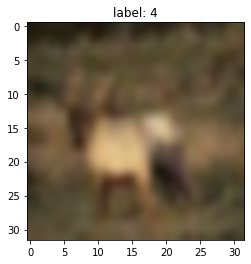

In [ ]:
# 데이터 하나의 형태
image, label = cifar_train.__getitem__(3) # 3번째 데이터

# 그리기
img = image.numpy() # 이미지 타입을 넘파이 타입으로 변환

# (3, 32, 32) > (32, 32, 3)
r,g,b = img[0,:,:], img[1,:,:], img[2,:,:]

#img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r,g,b

plt.title("label: %d" %label)
plt.imshow(img2,interpolation='bicubic')
plt.show()

# 정학도 측정 함수


In [ ]:
# 정학도 측정 함수
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader): # batch_size 만큼
        img = Variable(imgs,volatile = True).cuda() # x
        label = Variable(labels).cuda() # y
        
        output = imodel.forward(img) #forward prop.
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    
    print("Accuracy of Test Data : {}" .format(100*correct/total))

# 3. 데이터 로드 함수

In [ ]:
train_loader = torch.utils.data.DataLoader(list(cifar_train)[:], batch_size = batch_size, shuffle = True, num_workers = 2, drop_last = True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size = batch_size, shuffle = False, num_workers = 2, drop_last = True)

# 4. 모델 선언


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding = 1),
            nn.ReLU(),
            #nn.Dropout2d(0.25),  # (2) drop out
            #nn.BatchNorm2d(16), # (6) Batch normalization
            nn.Conv2d(16, 32, 3, padding = 1),
            nn.ReLU(),
            #nn.Dropout2d(0.25),
            #nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.ReLU(),
            #nn.Dropout2d(0.25),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2)
        )  
        self.fc_layer = nn.Sequential(
            nn.Linear(64*8*8, 100),
            nn.ReLU(),
            #nn.Dropout2d(0.25),
            #nn.BatchNorm1d(100),
            nn.Linear(100, 10)
        )
        
        # weight initialization
#        for m in self.modules():
#            if isinstance(m, nn.Conv2d): # ReLu 일때
#                init.kaiming_normal_(m.weight.data)
#                m.bias.data.fill_(0)
#            if isinstance(m, nn.Linear):
#                init.kaiming_normal_(m.weight.data)
#                m.bias.data.fill_(0)        
    
    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        
        return out
model = CNN().cuda()

# 5. loss_func, optimizer

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.2)

# 6. 학습

In [ ]:
model.train()
for i in range(num_epoch):
    for j,[image, label] in enumerate(train_loader):
        x = Variable(image).cuda()
        y_ = Variable(label).cuda()
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
        
        if j%4000==0:
            print(i, j, loss)

0 0 tensor(2.2936, device='cuda:0', grad_fn=<NllLossBackward>)
1 0 tensor(2.2921, device='cuda:0', grad_fn=<NllLossBackward>)
2 0 tensor(1.8411, device='cuda:0', grad_fn=<NllLossBackward>)
3 0 tensor(2.2556, device='cuda:0', grad_fn=<NllLossBackward>)
4 0 tensor(1.2383, device='cuda:0', grad_fn=<NllLossBackward>)
5 0 tensor(1.5928, device='cuda:0', grad_fn=<NllLossBackward>)
6 0 tensor(1.8882, device='cuda:0', grad_fn=<NllLossBackward>)
7 0 tensor(1.2554, device='cuda:0', grad_fn=<NllLossBackward>)
8 0 tensor(1.1581, device='cuda:0', grad_fn=<NllLossBackward>)
9 0 tensor(1.5889, device='cuda:0', grad_fn=<NllLossBackward>)
10 0 tensor(1.2520, device='cuda:0', grad_fn=<NllLossBackward>)
11 0 tensor(1.5204, device='cuda:0', grad_fn=<NllLossBackward>)
12 0 tensor(1.2857, device='cuda:0', grad_fn=<NllLossBackward>)
13 0 tensor(1.1679, device='cuda:0', grad_fn=<NllLossBackward>)
14 0 tensor(0.9478, device='cuda:0', grad_fn=<NllLossBackward>)
15 0 tensor(1.2865, device='cuda:0', grad_fn=<NllL

# 기본형

기본형 1차 정확도 ( epoch 1, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 13.039999961853027


기본형 2차 정확도 ( epoch 5, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 44.279998779296875


기본형 3차 정확도 ( epoch 10, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 53.87999725341797


기본형 4차 정확도 ( epoch 20, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 63.57999801635742


# Dropout

Drop out 1차 정확도 ( epoch 1, lr 0.002, bs 16, Drop 0.2)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 15.460000038146973


Drop out 2차 정확도 ( epoch 5, lr 0.002, bs 16, Drop 0.2)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 37.55999755859375


Drop out 3차 정확도 ( epoch 10, lr 0.002, bs 16, Drop 0.2)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 46.07999801635742


Drop out 4차 정확도 ( epoch 20, lr 0.002, bs 16, Drop 0.2)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 55.47999954223633


# Dropout 확률에 따른 정확도 ( Drop 0.2 / epoch 10 = 46.07999801635742)

Drop out 변경 1차 정확도 ( epoch 10, lr 0.002, bs 16, Drop 0.1)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 50.939998626708984


Drop out 변경 2차 정확도 ( epoch 10, lr 0.002, bs 16, Drop 0.15)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 48.61000061035156


Drop out 변경 3차 정확도 ( epoch 10, lr 0.002, bs 16, Drop 0.25)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 45.07999801635742


Drop out 변경 4차 정확도 ( epoch 10, lr 0.002, bs 16, Drop 0.3)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 47.349998474121094


Drop out 변경 5차 정확도 ( epoch 10, lr 0.002, bs 16, Drop 0.4)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 44.02000045776367


Drop out 변경 6차 정확도 ( epoch 10, lr 0.002, bs 16, Drop 0.5)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 35.23999786376953


# Data Argumentation

Data argumetation 1차 정확도 ( epoch 1, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 11.519999504089355


Data argumetation 2차 정확도 ( epoch 5, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 24.420000076293945


Data argumetation 3차 정확도 ( epoch 10, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 20.619998931884766


Data argumetation 4차 정확도 ( epoch 20, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 24.81999969482422


Data argumetation 5차 정확도 ( epoch 40, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 24.349998474121094


Data argumetation 6차 정확도 ( epoch 80, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 24.69999885559082


# Weight initialization

Weight initialization 1차 정확도 ( epoch 1, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 44.12999725341797


Weight initialization 2차 정확도 ( epoch 5, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 58.869998931884766


Weight initialization 3차 정확도 ( epoch 10, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 67.0999984741211


Weight initialization 4차 정확도 ( epoch 20, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 69.88999938964844


# Data Normalization

Data Normalization 1차 정확도 ( epoch 1, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 27.619998931884766


Data Normalization 2차 정확도 ( epoch 5, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 51.07999801635742


Data Normalization 3차 정확도 ( epoch 10, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 59.91999816894531


Data Normalization 4차 정확도 ( epoch 20, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 67.31999969482422


# Batch Normalization

Batch Normalization 1차 정확도 ( epoch 1, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 62.87999725341797


Batch Normalization 2차 정확도 ( epoch 5, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 71.23999786376953


Batch Normalization 3차 정확도 ( epoch 10, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 72.48999786376953


Batch Normalization 4차 정확도 ( epoch 20, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 72.72000122070312


# Adam Optimizer

Adam Optimizer 1차 정확도 ( epoch 1, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 58.13999938964844


Adam Optimizer 2차 정확도 ( epoch 5, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 67.65999603271484


Adam Optimizer 3차 정확도 ( epoch 10, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 68.12999725341797


Adam Optimizer 4차 정확도 ( epoch 20, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 64.65999603271484


# Learning Rate decay

Learning Rate Decay 1차 정확도 ( epoch 50, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 64.75


Learning Rate Decay 2차 정확도 ( epoch 75, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 65.72999572753906


Learning Rate Decay 3차 정확도 ( epoch 100, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 65.56999969482422


Learning Rate Decay 4차 정확도 ( epoch 150, lr 0.002, bs 16)

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data : 65.48999786376953


# 조합